# Comparing Vegas generated without scanning with the KDE prediction in observables

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from parameters_dict import physics_parameters
from exp_analysis_class import exp_analysis

In [4]:
case = 'heavy'
save_folder = ('../fig/3_comparison_observables/' + case + '/')
!mkdir -p $save_folder
my_exp_analysis = exp_analysis(case)
my_exp_analysis.load_df_base(1000000)

/bin/bash: port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_port_used'
/bin/bash: wait_until_port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_wait_until_port_used'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
/bin/bash: find_port: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_find_port'
/bin/bash: random_number: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_random_number'
/bin/bash: helmod: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_helmod'
/bin/bash: source_helpers: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_source_h

In [5]:
my_exp_analysis.load_grid_dfs()

In [35]:
import matplotlib.patches as patches

def kde_variable_plot(var1, var2, range, bins, m4mz, exp_analysis_obj, selection='True'):
    this_weight = exp_analysis_obj.kde_on_a_point(m4mz) 
    selection_weights = exp_analysis_obj.df_base.eval(selection)
    this_weight *= selection_weights
    
    kde_prediction, bin_edges = np.histogram(exp_analysis_obj.df_base[var1, var2],
             range=range,
             bins=bins,
             weights=this_weight,
            )
    
    kde_errors2 = np.histogram(exp_analysis_obj.df_base[var1, var2],
                 range=range,
                 bins=bins,
                 weights=this_weight**2,
                )[0]
    
    plt.plot(bin_edges,
             np.append(kde_prediction, [0]),
             ds='steps-post',
             label=f'kde prediction: {kde_prediction.sum():.2g} '\
                f'$\pm$ {100*np.sqrt(kde_errors2.sum())/kde_prediction.sum():.2g}%')
    
    kde_errors = np.sqrt(kde_errors2)
    for edge_left, edge_right, pred, err in zip(bin_edges[:-1], bin_edges[1:], kde_prediction, kde_errors):
            plt.gca().add_patch(
                patches.Rectangle(
                    (edge_left, pred-err),
                    edge_right-edge_left,
                    2 * err,
                    hatch="\\\\\\\\\\",
                    fill=False,
                    linewidth=0,
                    alpha=0.4,
                )
            )
            
    plt.legend(frameon=False)
    plt.title(f'selection = {selection}')
    plt.xlabel(f'{var1} - {var2}')    
    plt.ylabel(f'Number of entries')
    
def kde_to_noscan_comparison(var1, var2, range, bins, m4mz, exp_analysis_obj, selection='True'):
    assert m4mz in list(exp_analysis_obj.dfs.keys())
    kde_variable_plot(var1, var2, range, bins, m4mz, exp_analysis_obj, selection)
    
    no_scan = exp_analysis_obj.dfs[m4mz]
    selection_weights = no_scan.eval(selection)
    actual_weight = no_scan['actual_weight', '']
    this_weight = selection_weights * actual_weight
    no_scan_pred, bin_edges = np.histogram(no_scan[var1, var2],
                                             range=range,
                                             bins=bins,
                                             weights=this_weight,
                                            )
    no_scan_pred_err = np.histogram(no_scan[var1, var2],
                                             range=range,
                                             bins=bins,
                                             weights=this_weight**2,
                                            )[0]
    plt.errorbar((bin_edges[1:]+bin_edges[:-1])/2, no_scan_pred, 
             yerr=np.sqrt(no_scan_pred_err),
             fmt='k.',
             label=f'no scanning: {no_scan_pred.sum():.2g} '\
                    f'$\pm$ {100*np.sqrt(no_scan_pred_err.sum())/no_scan_pred.sum():.2g}%')
    
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.legend(frameon=False)
    plt.title(f'selection = {selection} @ m4={m4mz[0]}, mz={m4mz[1]}')

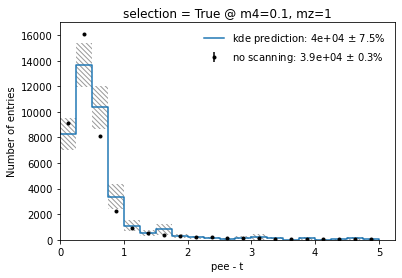

In [36]:
kde_to_noscan_comparison(var1='pee', 
                         var2='t', 
                         range=(0, 5), 
                         bins=20, 
                         m4mz=(0.1, 1), 
                         exp_analysis_obj=my_exp_analysis)

# This is all pretty old stuff

## Test comparison between KDE and truth

In [5]:
case = 'light'
pars = {}
pars['heavy'] = {
    'm4' : [0.1, 0.2, 0.3, 0.4],
    'mz_prime': [1.25],
}
pars['light'] = {
    'm4' : [0.2, 0.3, 0.4], 
    'mz_prime': [0.03, 0.045, 0.06],
}

ctaus = [1, 5, 10, 20, 50, 100, 200]
!mkdir -p ../../fig/kde_test_2d/comparison_kde_truth/
save_folder = "../../fig/kde_test_2d/comparison_kde_truth/"
produce_samples = False

#generation part
if produce_samples:
    for m4, mz_prime in itertools.product(pars[case]['m4'], pars[case]['mz_prime']):
        print(m4, mz_prime)
        if case == 'light':
            dark_gen_run = f'cd ..; ./dark_gen.py --M4 {m4} --mzprime {mz_prime} --UMU4 8e-9 --alpha_dark 0.25 --alpha_epsilon2 2e-10 --hierarchy light_mediator --neval 100000 --noplot'
        elif case == 'heavy':
            dark_gen_run = f'cd ..; ./dark_gen.py --M4 {m4} --mzprime {mz_prime} --UMU4 2.2e-7 --alpha_dark 0.4 --epsilon2 4.6e-4 --neval 100000 --noplot --hierarchy heavy_mediator'
        else:
            print('No good case selected')
        stream = os.popen(dark_gen_run)
        print(stream.read())

In [19]:
# 1d histograms with one specific variable
var_1 = 'ee_energy'
var_2 = ''
hist_range = [0, 5]
bins = 20
ctau = 1
smooth_m4 = 0.03
smooth_mz = 0.005

kde_total = dict(zip(['no_selection', 'cut_based'], [[], []]))
truth_total = dict(zip(['no_selection', 'cut_based'], [[], []]))

for m4, mz in itertools.product(pars[case]['m4'], pars[case]['mz_prime']):
    df = pd.read_pickle(f'../data/nd280_nu/3plus1/m4_{m4}_mzprime_{mz}/MC_m4_{m4}_mzprime_{mz}.pckl')
    initialise_df(df)
    for selection_step in ['no_selection', 'cut_based']:

        aux_out = output_distrib(df_base, var_1, var_2, bins, hist_range, m4, mz, ctau, smooth_m4, smooth_mz, selection_step)
        kde_total[selection_step].append(aux_out)

        truth_weights = df['actual_weight', '']*df[selection_step, '']
        plt.hist(df[var_1, var_2],
             range=hist_range,
             bins=bins,
             weights=truth_weights,
             histtype='step',
             label=f'truth with $m_4$ = {m4:.2g} GeV, $m_Z$ = {mz:.2g} GeV\nexpected events = {truth_weights.sum():.1f}')
        truth_total[selection_step].append(truth_weights.sum())
        plt.autoscale()
        plt.legend(frameon=False)
        plt.savefig(save_folder+f"case_{case}_m4_{m4}_mz_{mz}_N_{n_evt}_{selection_step}.png", bbox_inches='tight', dpi=250)
        plt.close()

no_selection
m4 = 0.2, mz = 0.03, kde = 1.9e+03, truth = 1.9e+03, ratio = 1
cut_based
m4 = 0.2, mz = 0.03, kde = 7.3e+02, truth = 6.8e+02, ratio = 1.1
no_selection
m4 = 0.2, mz = 0.045, kde = 7.1e+02, truth = 1.2e+03, ratio = 0.58
cut_based
m4 = 0.2, mz = 0.045, kde = 2.5e+02, truth = 4.2e+02, ratio = 0.59
no_selection
m4 = 0.2, mz = 0.06, kde = 4.1e+02, truth = 6.6e+02, ratio = 0.63
cut_based
m4 = 0.2, mz = 0.06, kde = 1.5e+02, truth = 2.2e+02, ratio = 0.66
no_selection
m4 = 0.3, mz = 0.03, kde = 6e+02, truth = 6.8e+02, ratio = 0.87
cut_based
m4 = 0.3, mz = 0.03, kde = 2.8e+02, truth = 3.2e+02, ratio = 0.87
no_selection
m4 = 0.3, mz = 0.045, kde = 3e+02, truth = 3.7e+02, ratio = 0.79
cut_based
m4 = 0.3, mz = 0.045, kde = 1.2e+02, truth = 1.5e+02, ratio = 0.78
no_selection
m4 = 0.3, mz = 0.06, kde = 1.9e+02, truth = 2e+02, ratio = 0.98
cut_based
m4 = 0.3, mz = 0.06, kde = 72, truth = 75, ratio = 0.97
no_selection
m4 = 0.4, mz = 0.03, kde = 2.5e+02, truth = 2.5e+02, ratio = 0.98
cut_bas

In [12]:
# 2d ratio of kde and truth
smooth_m4 = 0.03
smooth_mz = 0.005
ctau = 10

kde_total = dict(zip(['no_selection', 'cut_based'], [[], []]))
truth_total = dict(zip(['no_selection', 'cut_based'], [[], []]))
likes_kde = dict(zip(['no_selection', 'cut_based'], [[], []]))
likes_truth = dict(zip(['no_selection', 'cut_based'], [[], []]))
ratios = dict(zip(['no_selection', 'cut_based'], [[], []]))
sigma_ratios = dict(zip(['no_selection', 'cut_based'], [[], []]))

for m4, mz in itertools.product(pars[case]['m4'], pars[case]['mz_prime']):
    df = pd.read_pickle(f'../data/nd280_nu/3plus1/m4_{m4}_mzprime_{mz}/MC_m4_{m4}_mzprime_{mz}.pckl')
    initialise_df(df)
    for selection_step in ['no_selection', 'cut_based']:
        mu_kde, sigma2_kde = mu_sigma2_of_theta(df_base, m4, mz, ctau, smooth_m4, smooth_mz, selection_step)
        kde_total[selection_step].append(mu_kde)
        likes_kde[selection_step].append(LEff(0, mu_kde, sigma2_kde))

        mu_truth = (df['actual_weight', '']*df[selection_step, '']).sum()
        sigma2_truth = ((df['actual_weight', '']*df[selection_step, ''])**2).sum()
        truth_total[selection_step].append(mu_truth)
        likes_truth[selection_step].append(LEff(0, mu_truth, sigma2_truth))

        ratio = mu_kde/mu_truth
        ratios[selection_step].append(ratio)
        
        sigma_ratio = ratio*np.sqrt(sigma2_kde/(mu_kde**2) + sigma2_truth/(mu_truth**2))
        sigma_ratios[selection_step].append(sigma_ratio)
        print(selection_step)
        print(f"m4 = {m4}, mz = {mz}, kde = {mu_kde:.2g}, truth = {mu_truth:.2g}, ratio = {ratio:.2g} +/- {sigma_ratio:.2g}")
        print(f"relative sigma_kde = {np.sqrt(sigma2_kde)/mu_kde:.2g}, sigma_truth = {np.sqrt(sigma2_truth)/mu_truth:.2g}")

no_selection
m4 = 0.2, mz = 0.03, kde = 1.9e+03, truth = 1.9e+03, ratio = 1 +/- 0.0055
relative sigma_kde = 0.0049, sigma_truth = 0.0026
cut_based
m4 = 0.2, mz = 0.03, kde = 7.3e+02, truth = 6.8e+02, ratio = 1.1 +/- 0.0088
relative sigma_kde = 0.0071, sigma_truth = 0.0042
no_selection
m4 = 0.2, mz = 0.045, kde = 7.1e+02, truth = 1.2e+03, ratio = 0.58 +/- 0.0055
relative sigma_kde = 0.009, sigma_truth = 0.0033
cut_based
m4 = 0.2, mz = 0.045, kde = 2.5e+02, truth = 4.2e+02, ratio = 0.59 +/- 0.0085
relative sigma_kde = 0.013, sigma_truth = 0.0054
no_selection
m4 = 0.2, mz = 0.06, kde = 4.1e+02, truth = 6.6e+02, ratio = 0.63 +/- 0.011
relative sigma_kde = 0.017, sigma_truth = 0.0031
cut_based
m4 = 0.2, mz = 0.06, kde = 1.5e+02, truth = 2.2e+02, ratio = 0.66 +/- 0.017
relative sigma_kde = 0.025, sigma_truth = 0.0052
no_selection
m4 = 0.3, mz = 0.03, kde = 6e+02, truth = 6.8e+02, ratio = 0.87 +/- 0.0049
relative sigma_kde = 0.0046, sigma_truth = 0.0032
cut_based
m4 = 0.3, mz = 0.03, kde = 2.

In [14]:
def create_bin_edges_from_array(ar):
    ar_min = 2* ar[0] - ar[1]
    ar_max = 2* ar[-1] - ar[-2]
    new_ar = np.array([ar_min] + list(ar) + [ar_max])
    return np.array((new_ar[1:] + new_ar[:-1])/2)

In [41]:
m4_centres = np.array(pars[case]['m4'])
mz_centres = np.array(pars[case]['mz_prime'])
m4_edges = create_bin_edges_from_array(m4_centres)
mz_edges = create_bin_edges_from_array(mz_centres)

ratio_total = {}
for sel in kde_total.keys():
    this_ratio = np.array(ratios[sel]).reshape(len(pars[case]['m4']), len(pars[case]['mz_prime']))
    this_sigma_ratio = np.array(sigma_ratios[sel]).reshape(len(pars[case]['m4']), len(pars[case]['mz_prime']))
    plt.pcolormesh(m4_edges, mz_edges, this_ratio.T)
    for i in range(len(m4_centres)):
        for j in range(len(mz_centres)):
            text = plt.text(pars[case]['m4'][j], pars[case]['mz_prime'][i], f"{this_ratio[j, i]:.3g} $\pm$ {this_sigma_ratio[j, i]:.1g}",
                            ha="center", va="center", color="k")
    plt.colorbar()
    plt.xlabel(r'$m_4$ [GeV]')
    plt.ylabel(r'$m_Z$ [GeV]')
    plt.title(f'KDE estimate/truth ratio at {sel}')
    plt.savefig(save_folder+f"kde_truth_ratio_2d_summary_case_{case}_N_{n_evt}_{sel}.png", bbox_inches='tight', dpi=250)
    plt.close()

In [28]:
m4_centres = np.array(pars[case]['m4'])
mz_centres = np.array(pars[case]['mz_prime'])
m4_edges = create_bin_edges_from_array(m4_centres)
mz_edges = create_bin_edges_from_array(mz_centres)

likes = dict(zip(['kde', 'truth'], [likes_kde, likes_truth]))
for sel in kde_total.keys():
    for mode in ['kde', 'truth']:
        this_like = -1*np.array(likes[mode][sel]).reshape(len(pars[case]['m4']), len(pars[case]['mz_prime']))
        this_like -= this_like.min()
        plt.pcolormesh(m4_edges, mz_edges, this_like.T)
        for i in range(len(m4_centres)):
            for j in range(len(mz_centres)):
                text = plt.text(pars[case]['m4'][j], pars[case]['mz_prime'][i], f"{this_like[j, i]:.3g}",
                                ha="center", va="center", color="k")
        plt.colorbar()
        plt.xlabel(r'$m_4$ [GeV]')
        plt.ylabel(r'$m_Z$ [GeV]')
        plt.title(f'Effective likelihood of seeing 0 events\nestimated with {mode} at {sel}')
        plt.savefig(save_folder+f"likelihood_profile_{mode}_case_{case}_N_{n_evt}_{sel}.png", bbox_inches='tight', dpi=250)
        plt.close()